# unified code for python file in backend

model.py

In [1]:
import numpy as np
import torch
import cv2
import lungs_finder as lf #pip install git+https://github.com/dirtmaxim/lungs-finder
import matplotlib.pyplot as plt
import os

from albumentations.core.composition import *
from albumentations.pytorch import ToTensor, ToTensorV2
from albumentations.augmentations.transforms import *

threshold = 0.5

fake_images = ["./fake_images/"+img for img in os.listdir('./fake_images/')]

preprocess = Compose([Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), Resize(224, 224), ToTensorV2()])

# ---------- HELPERS FOR VISUALIZATION
"""
gradcam wrapperg
"""
class GradCam:
    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        self.hooks = []
        self.fmap_pool = dict()
        self.grad_pool = dict()

        def forward_hook(module, input, output):
            self.fmap_pool[module] = output.detach().cpu()
        def backward_hook(module, grad_in, grad_out):
            self.grad_pool[module] = grad_out[0].detach().cpu()
        
        for layer in layers:
            self.hooks.append(layer.register_forward_hook(forward_hook))
            self.hooks.append(layer.register_backward_hook(backward_hook))

    def close(self):
        for hook in self.hooks:
            hook.remove()

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.close()

    def __call__(self, *args, **kwargs):
        self.model.zero_grad()
        return self.model(*args, **kwargs)

    def get(self, layer):
        assert layer in self.layers, f'{layer} not in {self.layers}'
        fmap_b = self.fmap_pool[layer] # [N, C, fmpH, fmpW]
        grad_b = self.grad_pool[layer] # [N, C, fmpH, fmpW]

        grad_b = torch.nn.functional.adaptive_avg_pool2d(grad_b, (1, 1)) # [N, C, 1, 1]
        gcam_b = (fmap_b * grad_b).sum(dim=1, keepdim=True) # [N, 1, fmpH, fmpW]
        gcam_b = torch.nn.functional.relu(gcam_b)

        return gcam_b
    
"""
guidedbackprop wrapper
"""
class GuidedBackPropogation:
    def __init__(self, model):
        self.model = model
        self.hooks = []

        def backward_hook(module, grad_in, grad_out):
            if isinstance(module, torch.nn.ReLU):
                return tuple(grad.clamp(min=0.0) for grad in grad_in)

        for name, module in self.model.named_modules():
            self.hooks.append(module.register_backward_hook(backward_hook))

    def close(self):
        for hook in self.hooks:
            hook.remove()

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.close()

    def __call__(self, *args, **kwargs):
        self.model.zero_grad()
        return self.model(*args, **kwargs)
    
    def get(self, layer):
        return layer.grad.cpu()

"""
gradcam predictor (also returns model prediction)
"""
def get_grad(model,img):

    torch.set_grad_enabled(True)
    
    gcam = GradCam(model, [model.conv_head])

    out = gcam(img)

    mask = (out>=threshold)[0]
    out[0:1, mask].sum().backward()

    grad = gcam.get(model.conv_head)[0:1]
    grad = torch.nn.functional.interpolate(grad, [224,224], mode='bilinear', align_corners=False)

    # we return everything only for 1 image
    return out[0], grad[0,0,:,:]

"""
guided backprop predictor
"""
def get_gbprop(model, img):

    torch.set_grad_enabled(True)
    
    gdbp = GuidedBackPropogation(model)
    inp_b = img.requires_grad_() # Enable recording inp_b's gradient
    out_b = gdbp(inp_b)
    mask = (out_b>=threshold)[0]
    out_b[0:1, mask].sum().backward()

    grad_b = gdbp.get(img)[0:1] # [N, 3, inpH, inpW]
    grad_b = grad_b.mean(dim=1, keepdim=True).abs() # [N, 1, inpH, inpW]
        
    return grad_b.squeeze()
    
def normalize(img):
    out = img-img.min()
    out/=(out.max()+1e-7)
    return out
    

# --------- END OF HELPERS FOR VISUALIZATION--------


# --------- model functions
    
def load_model(ckpt_path):
    """
    function us used to load our model from checkpoint and return it
    """
    torch.hub.list('rwightman/gen-efficientnet-pytorch', force_reload=False)  
    model = torch.hub.load('rwightman/gen-efficientnet-pytorch', 'efficientnet_b3', pretrained=True)

    model.classifier = torch.nn.Sequential(torch.nn.Linear(1536,14), torch.nn.Sigmoid())

    class Fixer(torch.nn.Module):
        def __init__(self, model):
            super(Fixer, self).__init__()
            self.model = model

    model = Fixer(model)
    model.load_state_dict(torch.load(ckpt_path)['state_dict'])
    model = model.model
    
    model.train()
    
    return model


def convert_prediction_to_pathology(y_pred):
    """
    this function is used to convert vector of anwers to vector of string representations
    e.g. [1,1,0,0,0,0,...] to ['Atelec...','Cadioomeg...']
    """
    pathologies = np.asarray(['Atelectasis',
                 'Cardiomegaly',
                 'Consolidation',
                 'Edema',
                 'Effusion',
                 'Emphysema',
                 'Fibrosis',
                 'Hernia',
                 'Infiltration',
                 'Mass',
                 'Nodule',
                 'Pleural_Thickening',
                 'Pneumonia',
                 'Pneumothorax'])
    
    y_pred = y_pred.clone().detach().cpu().numpy()
    mask = (y_pred>=threshold).astype(bool)
    
    return pathologies[mask].tolist()

def prepare_image(path_to_image):
    """
    image preprocessor
    
    Args:
        path_to_image: string with image location
    """
    image = cv2.imread(path_to_image).astype(float)
    
    if image.ndim==2 or (image.ndim==3 and image.shape[2]==1):
        image = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif image.ndim==3 and image.shape[2]==4:
        image = image[:,:,:3]
    
    image = preprocess(image=image)['image'].unsqueeze(0)
    return image

def prepare_fake():
    return torch.stack([prepare_image(img) for img in fake_images]).squeeze()

def predict_visual(model, path_to_image, isCuda = False):
    """
    function is used to predict labels and visualise image
    
    Args:
        path_to_image: str with image location (0-255)
        model: our loaded model
        isCuda: bool flag, set to Treu to run on gpu
    """
    # sadly, gbrop can not be extract at the same time as gradcam
    # so we have to do two predictions for the same image
    image = prepare_image(path_to_image)
    image = torch.cat([image, prepare_fake()])
    
    if isCuda:
        image.to(torch.device('cuda'))
        model.to(torch.device('cuda'))
    
    image.require_grad = True
    pred, gcam = get_grad(model, image)
    gbprop = get_gbprop(model, image)
    
    # plt.imshow((np.repeat(normalize(img.squeeze().detach().cpu().numpy())[:,:,np.newaxis],3,2)+plt.cm.hot(normalize(gbprop*grad).detach().cpu().numpy())[:,:,:3])/2)
    visualization = normalize((gbprop*gcam).detach().cpu().numpy())
    visualization = normalize(visualization)
    
    orig = (normalize(image.detach().cpu().numpy()[0,0,:,:])*255).astype(np.uint8)

    visualization = plt.get_cmap('hot')(visualization)[:,:,:3]

    final = np.zeros(visualization.shape)
    right_lung_haar_rectangle = lf.find_right_lung_haar(orig)
    left_lung_haar_rectangle = lf.find_left_lung_haar(orig)

    if (right_lung_haar_rectangle is not None) and (left_lung_haar_rectangle is not None):
        x, y, width, height = right_lung_haar_rectangle
        final[y:y + height, x:x + width] = visualization[y:y + height, x:x + width]
        x, y, width, height = left_lung_haar_rectangle
        final[y:y + height, x:x + width] = visualization[y:y + height, x:x + width]
    else:
        final = visualization

    final = normalize(final + \
        cv2.cvtColor(orig, cv2.COLOR_GRAY2RGB).astype(
            np.float32)/255)
    
    return pred, final

def predict(model, path_to_image, isCuda = False):
    """
    used to predit labels only (to speed up the process)
    isCuda: bool flag, set to Treu to run on gpu
    """
    image = prepare_image(path_to_image)
    image = torch.cat([image, prepare_fake()])
    
    if isCuda:
        image.to(torch.device('cuda'))
        model.to(torch.device('cuda'))
    
    return model(image)[0]  

In [2]:
# model = load_model("/home/alexander/work/hackathon/models/temp_models/_ckpt_epoch_33_v0.ckpt")
model = load_model("/home/alexander/work/hackathon/models/temp_models/_ckpt_epoch_37.ckpt")
model.train()


Using cache found in /home/alexander/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /home/alexander/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


GenEfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SwishMe()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SwishMe()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SwishMe()
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv(
        (c

In [3]:
pred, vis = predict_visual(model,"/home/alexander/work/hackathon/chest-14/images/00014022_083.png") 
pred

tensor([1.7252e-02, 3.7464e-09, 9.9980e-01, 2.0156e-07, 1.7713e-04, 1.1531e-10,
        1.0000e+00, 3.4891e-08, 1.9891e-05, 8.7904e-05, 3.3545e-02, 5.8963e-05,
        2.8931e-08, 9.7534e-08], grad_fn=<SelectBackward>)

In [4]:
vis

array([[[0.01588591, 0.01588591, 0.01588591],
        [0.01588591, 0.01588591, 0.01588591],
        [0.01588591, 0.01588591, 0.01588591],
        ...,
        [0.02224027, 0.02224027, 0.02224027],
        [0.02224027, 0.02224027, 0.02224027],
        [0.02224027, 0.02224027, 0.02224027]],

       [[0.01588591, 0.01588591, 0.01588591],
        [0.01588591, 0.01588591, 0.01588591],
        [0.01588591, 0.01588591, 0.01588591],
        ...,
        [0.02541746, 0.02541746, 0.02541746],
        [0.01906309, 0.01906309, 0.01906309],
        [0.02224027, 0.02224027, 0.02224027]],

       [[0.01588591, 0.01588591, 0.01588591],
        [0.01588591, 0.01588591, 0.01588591],
        [0.01906309, 0.01906309, 0.01906309],
        ...,
        [0.01906309, 0.01906309, 0.01906309],
        [0.01906309, 0.01906309, 0.01906309],
        [0.01906309, 0.01906309, 0.01906309]],

       ...,

       [[0.02859464, 0.02859464, 0.02859464],
        [0.02859464, 0.02859464, 0.02859464],
        [0.03177182, 0

In [5]:
model.train()
pred = predict(model,"/home/alexander/work/hackathon/1.png")
pred

tensor([3.7781e-05, 2.2929e-13, 6.5438e-07, 1.3976e-07, 2.2854e-10, 3.1098e-05,
        2.2822e-10, 1.6577e-11, 3.1140e-04, 1.3999e-08, 1.4415e-07, 6.5813e-09,
        3.2397e-07, 4.5630e-06], grad_fn=<SelectBackward>)

In [6]:
convert_prediction_to_pathology(pred)

[]

In [7]:
vis.max()

0.9999999189818609

In [8]:
import matplotlib.pyplot as plt

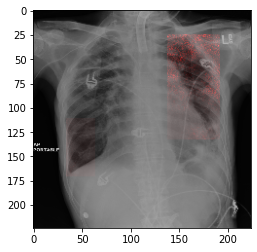

In [9]:
plt.imshow(vis)

# test prediction

In [10]:
import pandas as pd
df_only_labels = pd.read_csv('/home/alexander/work/hackathon/chest-14/Data_Entry_2017.csv')
df_only_labels

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168


In [11]:
for i, img in df_only_labels.iterrows():
#     pred, vis = predict_visual(model,'/home/alexander/work/hackathon/chest-14/images/'+img['Image Index']) 
    pred = predict(model,'/home/alexander/work/hackathon/chest-14/images/'+img['Image Index']) 
    print(f"True: {img['Finding Labels']} ; Pred: {convert_prediction_to_pathology(pred)}")
#     plt.imshow(vis)
#     plt.show()

True: Cardiomegaly ; Pred: ['Cardiomegaly']
True: Cardiomegaly|Emphysema ; Pred: ['Cardiomegaly', 'Emphysema']
True: Cardiomegaly|Effusion ; Pred: ['Cardiomegaly', 'Effusion']
True: No Finding ; Pred: []
True: Hernia ; Pred: ['Hernia']
True: Hernia ; Pred: ['Hernia']
True: Hernia ; Pred: ['Atelectasis', 'Hernia']
True: Hernia|Infiltration ; Pred: ['Hernia']
True: Hernia ; Pred: ['Hernia']
True: Hernia ; Pred: ['Hernia']
True: Hernia ; Pred: ['Hernia']
True: Hernia ; Pred: ['Hernia']
True: Mass|Nodule ; Pred: ['Mass', 'Nodule']
True: No Finding ; Pred: []
True: No Finding ; Pred: []
True: No Finding ; Pred: []
True: No Finding ; Pred: []
True: No Finding ; Pred: []
True: No Finding ; Pred: []
True: Infiltration ; Pred: ['Infiltration']
True: Effusion|Infiltration ; Pred: ['Effusion', 'Infiltration']
True: No Finding ; Pred: []
True: No Finding ; Pred: []
True: Cardiomegaly ; Pred: ['Cardiomegaly']
True: No Finding ; Pred: []
True: Nodule ; Pred: ['Fibrosis', 'Nodule']
True: Emphysema ; 

True: Cardiomegaly|Edema ; Pred: ['Cardiomegaly', 'Edema']
True: Cardiomegaly|Edema|Effusion|Infiltration ; Pred: ['Cardiomegaly', 'Edema', 'Effusion', 'Infiltration']
True: No Finding ; Pred: []
True: Infiltration ; Pred: ['Infiltration']
True: No Finding ; Pred: []
True: No Finding ; Pred: []
True: Atelectasis|Edema|Infiltration ; Pred: ['Atelectasis', 'Edema', 'Infiltration']
True: No Finding ; Pred: []
True: Atelectasis|Edema|Infiltration ; Pred: ['Atelectasis', 'Edema', 'Infiltration']
True: Cardiomegaly ; Pred: ['Cardiomegaly']
True: Atelectasis ; Pred: ['Atelectasis']
True: Cardiomegaly ; Pred: ['Cardiomegaly']
True: Cardiomegaly ; Pred: ['Cardiomegaly']
True: Edema|Effusion|Infiltration ; Pred: ['Edema', 'Effusion', 'Infiltration']
True: Edema|Effusion|Infiltration ; Pred: ['Edema', 'Infiltration']
True: Cardiomegaly|Infiltration ; Pred: ['Cardiomegaly', 'Infiltration']
True: Cardiomegaly|Edema ; Pred: ['Cardiomegaly', 'Edema']
True: Atelectasis|Cardiomegaly|Fibrosis ; Pred: ['

True: Effusion|Emphysema|Infiltration ; Pred: ['Effusion', 'Emphysema', 'Infiltration']
True: No Finding ; Pred: []
True: No Finding ; Pred: []
True: Effusion ; Pred: ['Effusion']
True: Pneumothorax ; Pred: []
True: No Finding ; Pred: []
True: No Finding ; Pred: []
True: Nodule ; Pred: ['Nodule']
True: Infiltration|Mass ; Pred: ['Infiltration', 'Mass']
True: Mass ; Pred: ['Effusion', 'Mass']
True: Infiltration ; Pred: ['Atelectasis', 'Infiltration']
True: Effusion|Infiltration ; Pred: ['Effusion', 'Infiltration']
True: No Finding ; Pred: []
True: No Finding ; Pred: []
True: Atelectasis ; Pred: ['Atelectasis']
True: Effusion ; Pred: ['Effusion']
True: Atelectasis|Infiltration ; Pred: ['Atelectasis', 'Infiltration']
True: No Finding ; Pred: []
True: Effusion|Fibrosis ; Pred: ['Effusion', 'Fibrosis', 'Pneumothorax']
True: Fibrosis ; Pred: ['Fibrosis']
True: Fibrosis ; Pred: ['Fibrosis']
True: Nodule ; Pred: ['Nodule']
True: Nodule ; Pred: ['Nodule']
True: No Finding ; Pred: []
True: No Fi

KeyboardInterrupt: 